This upload goes mostly around available public kernels
- Feature Engineering, Xgboost By Denis Larionov
- Hands on Data by Konstantin Yakovlev
- guoanjie notebook

In [18]:
# imports
import numpy as np
import pandas as pd
import os
import gc
import myutils
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle5 as pickle
from sklearn import feature_extraction
from itertools import product
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_importance

# Load and display the data

In [13]:
# data
DATA_FOLDER = 'data/'

train    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [3]:
# all data at once
myutils.display_all_data(train, items, item_categories, shops, test)


Train
(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0



Items
(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40



Item_categories
(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4



Shops
(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4



Test
(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Data preprocessing + additinal features

Train

In [4]:
# remove outliers
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [5]:
# find obviously faulty item (item price below zero)
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [6]:
# filling it with mean of the prices of this shop of that month
mean = train[(train.date_block_num == 4) & (train.shop_id == 32)].item_price.mean()
train.loc[train.item_price<0, 'item_price'] = mean

Shops

In [7]:
# fix duplicated shops
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [8]:
# transform categorical item_name to numerical city_code in shops
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

# features: name length, name word count, tf-idf
feature_cnt = 10
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
shops['shop_name_len'] = shops['shop_name'].map(len)  #Lenth of Shop Name
shops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

shops.drop(columns='shop_name', inplace=True)
shops.drop(columns='city', inplace=True)
shops.head()

,shop_id,city_code,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9
0,0,29,29,4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
1,1,29,29,4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.445753,0.895156
2,2,0,16,3,0.0,0.866844,0.000000,0.0,0.0,0.0,0.0,0.0,0.498580,0.000000
3,3,1,30,3,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000
4,4,2,24,4,0.0,0.000000,0.905675,0.0,0.0,0.0,0.0,0.0,0.423972,0.000000


Categories

In [9]:
# add 2 features + tf-idf 
feature_cnt = 10
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
item_categories['item_category_name_len'] = item_categories['item_category_name'].map(len)  #Lenth of Item Category Description
item_categories['item_category_name_wc'] = item_categories['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_categories['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_categories['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

#  transform categorical item_category_name to numerical type_code and subtype_code
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
# if subtype is nan then type
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])

item_categories.drop(columns='item_category_name', inplace=True)
item_categories.drop(columns='split', inplace=True)
item_categories.drop(columns='subtype', inplace=True)
item_categories.drop(columns='type', inplace=True)
item_categories.head()

,item_category_id,item_category_name_len,item_category_name_wc,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,type_code,subtype_code
0,0,23,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29
1,1,16,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9
2,2,16,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10
3,3,16,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11
4,4,16,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,13


In [10]:
# Items: correcting item_name, making two additional features with length and word count + tf-idf

import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
feature_cnt = 10
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
items['item_name_len'] = items['item_name'].map(len) #Lenth of Item Description
items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
    
items.drop(columns='item_name', inplace=True)

items.head()

,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9
0,0,40,20,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,76,45,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,40,13,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,40,13,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,40,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create feature matrix

In [11]:
# base matrix
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i] # changes every iteration
    # product is cartesian product
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [12]:
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [13]:
# add target
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0) # filling 0 when there is NA
                                .clip(0,20) # NB clip target here, cuz it might not be more than 20 for one month?
                                .astype(np.float16))

In [14]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [15]:
# add test set as 34th month
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,2,19,0.0,0.0
1,0,2,27,1.0,0.0
2,0,2,28,0.0,0.0
3,0,2,29,0.0,0.0
4,0,2,32,0.0,0.0


In [16]:
# combine everything
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_categories, on=['item_category_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,...,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,type_code,subtype_code
0,0,2,19,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,11,4
1,0,2,27,1.0,0.0,0,16,3,0.0,0.866844,...,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,5,10
2,0,2,28,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,8,55
3,0,2,29,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.58956,0.0,0.0,0.0,0.0,0.0,0.0,5,16
4,0,2,32,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,11,4


In [17]:
# lag function
def lag_feature(df, lags, col):
    import pandas as pd
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [18]:
# add lags to the target
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,...,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,0.0,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,0.0,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,0.0,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,0.0,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,0.0,11,4,NaN,NaN,NaN,NaN,NaN


In [19]:
# simple mean encodings with lags
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [20]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,...,item_category_name_tfidf_8,item_category_name_tfidf_9,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,8,55,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,5,16,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,0,16,3,0.0,0.866844,...,0.0,0.0,11,4,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# other small features
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,...,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,month,days
0,0,2,19,0.0,0.0,0,16,3,0.0,0.866844,...,11,4,NaN,NaN,NaN,NaN,NaN,NaN,0,31
1,0,2,27,1.0,0.0,0,16,3,0.0,0.866844,...,5,10,NaN,NaN,NaN,NaN,NaN,NaN,0,31
2,0,2,28,0.0,0.0,0,16,3,0.0,0.866844,...,8,55,NaN,NaN,NaN,NaN,NaN,NaN,0,31
3,0,2,29,0.0,0.0,0,16,3,0.0,0.866844,...,5,16,NaN,NaN,NaN,NaN,NaN,NaN,0,31
4,0,2,32,0.0,0.0,0,16,3,0.0,0.866844,...,11,4,NaN,NaN,NaN,NaN,NaN,NaN,0,31


In [22]:
# drop first 12 months (because of 12 month lag)
matrix = matrix[matrix.date_block_num > 11]

In [23]:
# fill nans
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,...,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,month,days
4488710,12,2,27,0.0,0.0,0,16,3,0.0,0.866844,...,5,10,0.0,0.0,0.0,0.0,1.0,0.411377,0,31
4488711,12,2,30,0.0,0.0,0,16,3,0.0,0.866844,...,11,4,0.0,0.0,0.0,0.0,0.0,0.411377,0,31
4488712,12,2,31,0.0,0.0,0,16,3,0.0,0.866844,...,11,1,0.0,0.0,0.0,0.0,0.0,0.411377,0,31
4488713,12,2,32,1.0,0.0,0,16,3,0.0,0.866844,...,11,4,0.0,0.0,0.0,0.0,0.0,0.411377,0,31
4488714,12,2,33,1.0,0.0,0,16,3,0.0,0.866844,...,11,1,1.0,2.0,0.0,0.0,1.0,0.411377,0,31


# Saving the data

In [25]:
matrix.to_pickle('data/data.pkl')
del matrix
del group
del items
del shops
del item_categories
del train
# leave test for submission
gc.collect();

# Splitting the data

In [8]:
data = pd.read_pickle('data/data.pkl')

In [9]:
# Splitting the data
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# Training on one XGBoost model

In [11]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

/Users/konstantin/anaconda3/envs/first-kaggle-1c/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/konstantin/anaconda3/envs/first-kaggle-1c/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:28:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:21] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12773	validation_1-rmse:1.12315
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.09111	validation_1-rmse:1.09153
[2]	validation_0-rmse:1.06309	validation_1-rmse:1.06514
[3]	validation_0-rmse:1.04412	validation_1-rmse:1.04733
[4]	validation_0-rmse:1.0051	validation_1-rmse:1.02915
[5]	validation_0-rmse:0.985783	validation_1-rmse:1.01351
[6]	validation_0-rmse:0.969415	validation_1-rmse:1.00081
[7]	validation_0-rmse:0.958409	validation_1-rmse:0.991622
[8]	validation_0-rmse:0.942941	validation_1-rmse:0.98345
[9]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [14]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

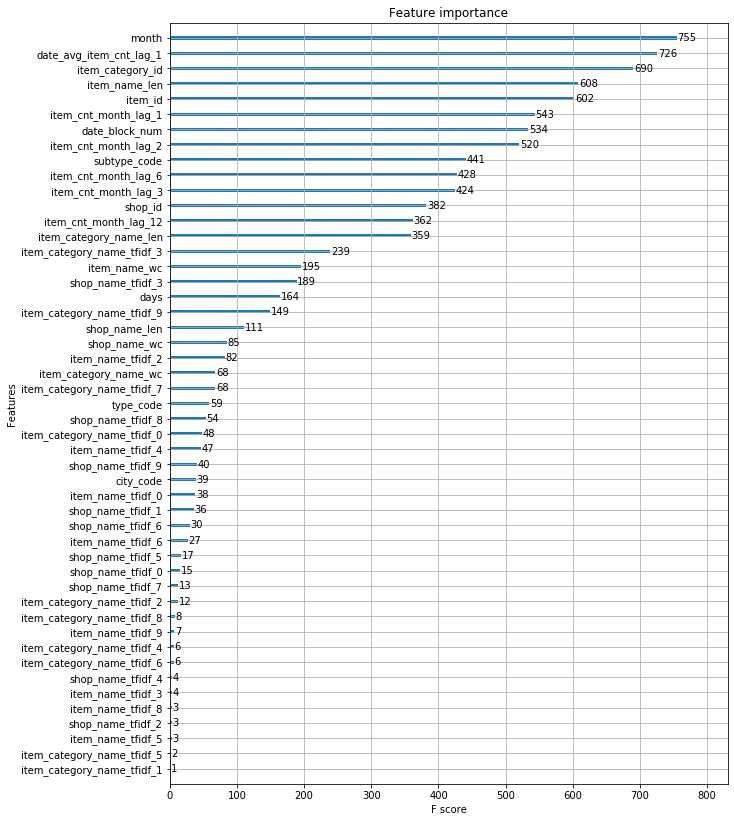

In [19]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [ ]:
pickle.dump(model, open("xgboost_pr_model.pickle.dat", "wb"))

# Keras LSTM